# Zillow Prediction 2017
## Goals:
* Construct an ML Regression model that predicts propery tax assessed values ('taxvaluedollarcnt') of Single Family Properties using attributes of the properties.

* Deliver a report that the data science team can read through and replicate, understand what steps were taken, why and what the outcome was.

* Make recommendations on what works or doesn't work in predicting these homes' values.

* Other key drivers:
    * Does lotsize_sf correlate with taxvalue?
    * Does finished_sf correlate with taxvalue?
    * How does the means for bedroomcnt and taxvalue compare?¶
    * How does the means for garagecarcnt and taxvalue compare?

## Imports

In [1]:
# necessary imports
import numpy as np
import os
import seaborn as sns
import scipy.stats as stat
from scipy.stats import pearsonr
from scipy.stats import pointbiserialr
import pandas as pd
import matplotlib.pyplot as plt
from pydataset import data
import warnings
warnings.filterwarnings("ignore")

import wrangle as wra
import env
import explore as exp
import evaluate as ev

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression 
from math import sqrt
import statsmodels.api as sm

from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import TweedieRegressor

## Acquire
* Data is pulled from Zillow dataset tables (properties_2017, predictions_2017) joined in SQL with a function updating to CSV in case of disconnection
* Includes only single family homes ('261' code) and 2017 transactions
* Contains 52441 rows with 8 columns
* Each row is a home/property
* Each column is a home feature

## Prepare

* stripped and renamed all columns appropriately for easy recall
* All nulls in rows deleted in data except 'garagecarcnt' where nulls equals '0'
* changed some floats to integers
* target value 'taxvalue' is continuous float
* handled outliers for better distribution and visuals

## Data Dictionary

| Features     | Definition                                                                                                           | Unit        |
|--------------|----------------------------------------------------------------------------------------------------------------------|-------------|
| taxvalue     | Assessed tax value of the home.                                                                                      | US Dollar   |
| bedroomcnt   | Number of bedrooms in home.                                                                                          |             |
| bathroomcnt  | Number of bathrooms in home including half baths.                                                                    |             |
| finished_sf  | Total of square feet in the finished home.                                                                           | Square Feet |
| garagecarcnt | Number of car spots in garage.                                                                                       |             |
| lotsize_sf   | Total of square feet for the property or lot.                                                                        | Square Feet |
| yearbuilt    | Year the home's build.                                                                                               |             |
| county       | County in which the property resides. a.k.a 'fips' 6037=Los Angeles County, 6059=Orange County,  6111=Ventura County |             |

In [2]:
# build query and look at data
zillow_query = """
        select bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, garagecarcnt, lotsizesquarefeet, yearbuilt, fips
        from properties_2017
        join predictions_2017 using (parcelid)
        where propertylandusetypeid = '261'
        AND YEAR(transactiondate) = 2017;
        """

df = wra.get_zillow_data(zillow_query)

df.head()

,Unnamed: 0,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,garagecarcnt,lotsizesquarefeet,yearbuilt,fips
0,0,4.0,3.5,3100.0,1023282.0,2.0,4506.0,1998.0,6059.0
1,1,2.0,1.0,1465.0,464000.0,1.0,12647.0,1967.0,6111.0
2,2,3.0,2.0,1243.0,564778.0,2.0,8432.0,1962.0,6059.0
3,3,4.0,3.0,2376.0,145143.0,NaN,13038.0,1970.0,6037.0
4,4,4.0,3.0,2962.0,773303.0,NaN,63000.0,1950.0,6037.0


In [3]:
# see if the rows are the desired 52K
df.shape

(52441, 9)

In [4]:
#rename columns
df.rename(columns={'calculatedfinishedsquarefeet': 'finished_sf', 'taxvaluedollarcnt': 'taxvalue', 'lotsizesquarefeet': 'lotsize_sf', 'fips': 'county'}, inplace=True)

## A brief look at the data

In [5]:
df = df.drop('Unnamed: 0', axis=1)
df.head()

,bedroomcnt,bathroomcnt,finished_sf,taxvalue,garagecarcnt,lotsize_sf,yearbuilt,county
0,4.0,3.5,3100.0,1023282.0,2.0,4506.0,1998.0,6059.0
1,2.0,1.0,1465.0,464000.0,1.0,12647.0,1967.0,6111.0
2,3.0,2.0,1243.0,564778.0,2.0,8432.0,1962.0,6059.0
3,4.0,3.0,2376.0,145143.0,NaN,13038.0,1970.0,6037.0
4,4.0,3.0,2962.0,773303.0,NaN,63000.0,1950.0,6037.0


## A summary of the data

In [7]:
# change all NaNs to '0' in 'garagecarcnt' column
df['garagecarcnt'] = df['garagecarcnt'].fillna(0)

In [8]:
df.head()

,bedroomcnt,bathroomcnt,finished_sf,taxvalue,garagecarcnt,lotsize_sf,yearbuilt,county
0,4.0,3.5,3100.0,1023282.0,2.0,4506.0,1998.0,6059.0
1,2.0,1.0,1465.0,464000.0,1.0,12647.0,1967.0,6111.0
2,3.0,2.0,1243.0,564778.0,2.0,8432.0,1962.0,6059.0
3,4.0,3.0,2376.0,145143.0,0.0,13038.0,1970.0,6037.0
4,4.0,3.0,2962.0,773303.0,0.0,63000.0,1950.0,6037.0


In [9]:
# drop all null rows
df.dropna(inplace=True)

In [10]:
# see how many rows we lost (452)
df.shape

(51959, 8)

In [11]:
#verify if any nulls in columns
df.isnull().sum()

bedroomcnt      0
bathroomcnt     0
finished_sf     0
taxvalue        0
garagecarcnt    0
lotsize_sf      0
yearbuilt       0
county          0
dtype: int64

In [12]:
# change some floats to integers for brevity
df[['bedroomcnt', 'finished_sf', 'taxvalue', 'garagecarcnt', 'lotsize_sf', 'yearbuilt', 'county']] = df[['bedroomcnt', 'finished_sf', 'taxvalue', 'garagecarcnt', 'lotsize_sf', 'yearbuilt', 'county']].astype(int)

In [13]:
# verify Dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51959 entries, 0 to 52440
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bedroomcnt    51959 non-null  int64  
 1   bathroomcnt   51959 non-null  float64
 2   finished_sf   51959 non-null  int64  
 3   taxvalue      51959 non-null  int64  
 4   garagecarcnt  51959 non-null  int64  
 5   lotsize_sf    51959 non-null  int64  
 6   yearbuilt     51959 non-null  int64  
 7   county        51959 non-null  int64  
dtypes: float64(1), int64(7)
memory usage: 3.6 MB


In [14]:
df.head()

,bedroomcnt,bathroomcnt,finished_sf,taxvalue,garagecarcnt,lotsize_sf,yearbuilt,county
0,4,3.5,3100,1023282,2,4506,1998,6059
1,2,1.0,1465,464000,1,12647,1967,6111
2,3,2.0,1243,564778,2,8432,1962,6059
3,4,3.0,2376,145143,0,13038,1970,6037
4,4,3.0,2962,773303,0,63000,1950,6037


In [15]:
# change 'fips' codes to names of 'county'
df.county = df.county.map({6037:'LA',6059:'Orange',6111:'Ventura'})

In [17]:
# shrinking outliers
df = df [df.finished_sf < 25_000]
df = df[df.lotsize_sf < 76_000]
df = df [df.taxvalue < df.taxvalue.quantile(.95)].copy()
df = df[df.taxvalue > df.taxvalue.quantile(.001)].copy()

In [18]:
# Our final total of rows going into the split
df.shape

(48866, 8)

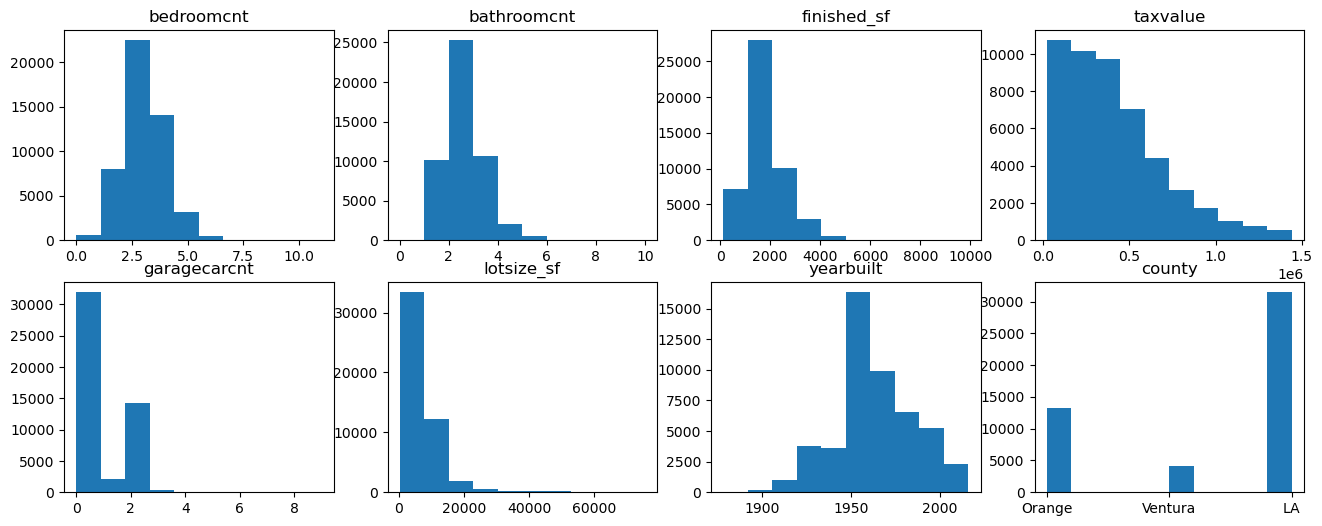

In [19]:
# show histogram of all features
ev.plot_hist_subplots(df)

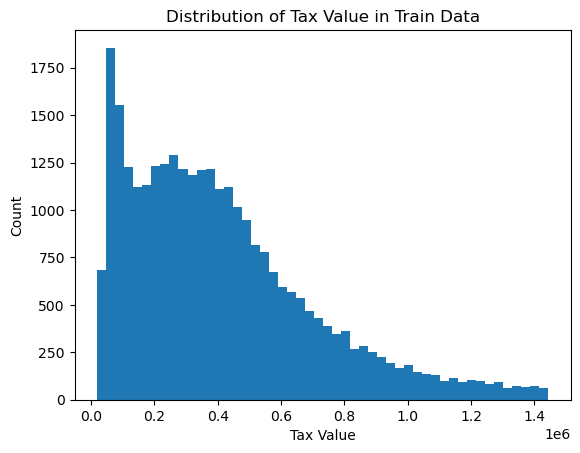

In [43]:
# Plot the distribution of the target variable 'taxvalue' in the train dataframe
plt.hist(train['taxvalue'], bins=50)
plt.xlabel('Tax Value')
plt.ylabel('Count')
plt.title('Distribution of Tax Value in Train Data')
plt.show()

In [21]:
# split data
train, validate, test = wra.split_data(df)

In [22]:
# show how many rows in each set
print (f'''{train.shape}
{validate.shape}
{test.shape}''')

(29319, 8)
(9773, 8)
(9774, 8)


## Scale Data

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48866 entries, 0 to 52440
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bedroomcnt    48866 non-null  int64  
 1   bathroomcnt   48866 non-null  float64
 2   finished_sf   48866 non-null  int64  
 3   taxvalue      48866 non-null  int64  
 4   garagecarcnt  48866 non-null  int64  
 5   lotsize_sf    48866 non-null  int64  
 6   yearbuilt     48866 non-null  int64  
 7   county        48866 non-null  object 
dtypes: float64(1), int64(6), object(1)
memory usage: 3.4+ MB


In [24]:
# scaled the data
train_scaled, validate_scaled, test_scaled = exp.scale_data(train, validate, test, to_scale=['bedroomcnt', 'bathroomcnt', 'finished_sf', 'garagecarcnt', 'lotsize_sf', 'yearbuilt'])

In [25]:
# this is what scaled looks like
train_scaled

,bedroomcnt,bathroomcnt,finished_sf,garagecarcnt,lotsize_sf,yearbuilt
0,0.272727,0.2500,0.184187,0.222222,0.084680,0.557971
1,0.272727,0.3125,0.362120,0.333333,0.075551,0.876812
2,0.272727,0.2500,0.223049,0.000000,0.096235,0.623188
3,0.363636,0.3750,0.383562,0.222222,0.166176,0.797101
4,0.272727,0.2500,0.230941,0.000000,0.084054,0.521739
...,...,...,...,...,...,...
29314,0.181818,0.2500,0.139815,0.000000,0.682521,0.362319
29315,0.363636,0.3750,0.329065,0.000000,0.093850,0.688406
29316,0.181818,0.1250,0.081894,0.000000,0.063437,0.318841
29317,0.272727,0.3750,0.315366,0.222222,0.089558,0.623188


## Explore

### Does lotsize_sf correlate with taxvalue?

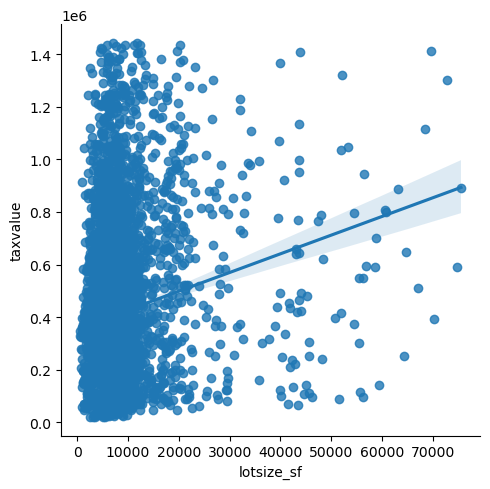

In [29]:
ev.lotsize_plot_lmplot(train)

* There seems to be a positive correlation between taxvalue and lotsize.

* In pearsonr The p-value measures the probability of observing a correlation coefficient. A p-value of less than 0.05 is often used as a threshold for statistical significance, indicating that the correlation coefficient is unlikely to have occurred by chance.

* H0 = There is no relationship between taxvalue and lotsize_sf
* Ha = There is a relationship between taxvalue and lotsize_sf

In [30]:
ev.lotsize_pearson_corr(train)

Pearson correlation coefficient: 0.150
P-value: 0.000


* The p-value is less than the 0.05 alpha. Therefore we reject the null hypothesis and there is evidence of correlation between lotsize_sf and taxvalue. We will send it on to modeling.

### Does finished_sf correlate with taxvalue?

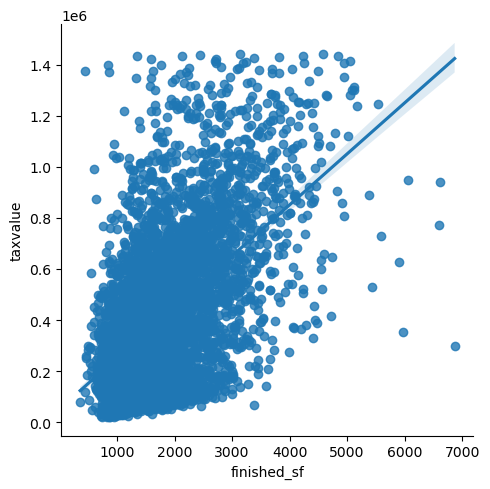

In [31]:
ev.finished_sf_plot_lmplot(train)

* There seems to be a positive correlation between taxvalue and finished_sf.
* In pearsonr The p-value measures the probability of observing a correlation coefficient. A p-value of less than 0.05 is often used as a threshold for statistical significance, indicating that the correlation coefficient is unlikely to have occurred by chance.

* H0 = There is no relationship between taxvalue and finished_sf
* Ha = There is a relationship between taxvalue and finished_sf

In [32]:
# Print the correlation coefficient and p-value
ev.finished_sf_pearson_corr(train, 'finished_sf', 'taxvalue')

Pearson correlation coefficient: 0.530
P-value: 0.000


* The p-value is less than the 0.05 alpha. Therefore we reject the null hypothesis and there is evidence of correlation between finished_sf and taxvalue. We will send it on to modeling.

### Is there significance in the means for bedroomcnt and taxvalue?

<Figure size 1800x1000 with 0 Axes>

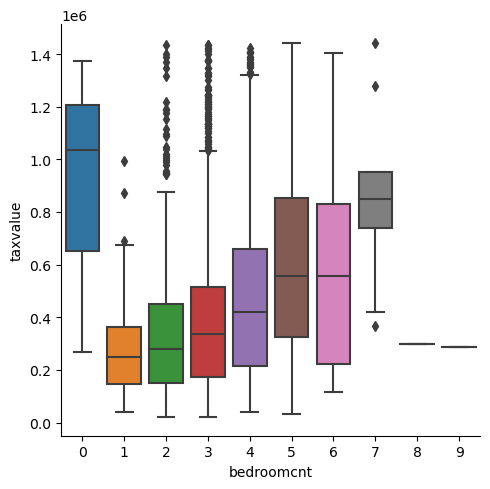

In [33]:
ev.bedroomcnt_plot_catplot(train)

* In the visual beyond the 0 bedroom flats there is a significance.
* H0 = There is no significance in the means for bedroomcnt and taxvalue
* Ha = * H0 = There is significance in the means for bedroomcnt and taxvalue

In [34]:
ev.bedroomcnt_anova_results(train)

F-statistic: 248.82254734849317
P-value: 0.0


* The p-value is less than the 0.05 alpha. Therefore we reject the null hypothesis and there is significance in the means for bedroomcnt and taxvalue. We will send it on to modeling.

### Is there significance in the means for garagecarcnt and taxvalue?

<Figure size 1800x1000 with 0 Axes>

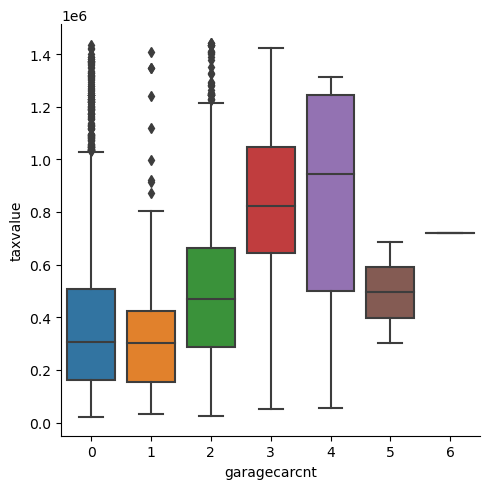

In [35]:
ev.garagecnt_plot_catplot(train)

* In the visual beyond the 0-1 car garage there is a positive correlation up to four car garage before the means drop off.
* H0 = There is no significance in the means for garagecarcnt and taxvalue
* Ha = * H0 = There is significance in the means for garagecarcnt and taxvalue

In [36]:
ev.garagecnt_anova_results(train)

F-Statistic: 340.47781003748173
P-Value: 0.0


* The p-value is less than the 0.05 alpha. Therefore we reject the null hypothesis and there is significance in the means for garagecnt and taxvalue. We will send it on to modeling.

### Exploration Summary

* The p-value is less than the 0.05 alpha. Therefore we reject the null hypothesis and there is evidence of correlation between lotsize_sf and taxvalue. 
* The p-value is less than the 0.05 alpha. Therefore we reject the null hypothesis and there is evidence of correlation between finished_sf and taxvalue.
* The p-value is less than the 0.05 alpha. Therefore we reject the null hypothesis and there is significance in the means for bedroomcnt and taxvalue. 
* The p-value is less than the 0.05 alpha. Therefore we reject the null hypothesis and there is significance in the means for garagecnt and taxvalue.

### Features I will model
* bedroomcnt, bathroomcnt, finished_sf, garagecarcnt, lotsize_sf, yearbuilt

### Modeling

* The purpose of modeling the features I have selected is to find the most accurate model for predicting taxvalue.

* The baseline accuracy we are trying to beat is 0% which is made up of the mean taxvalue. I will be using models Ordinary Least Squares (OLS_1), Multiple Reqression (OLS), Lasso/Lars (lars), Polynomial Regression (poly_2), Generalized Linear Model (GLM).

In [37]:
# drop county
train = train.drop('county', axis=1)
validate = validate.drop('county', axis=1)
test = test.drop('county', axis=1)

In [38]:
# build X_train
X_train, X_validate, X_test, y_train, y_validate, y_test = wra.get_X_train_val_test(train, validate, test, 'taxvalue', 'taxvalue')

In [39]:
# combine X_train and scaled
X_train_scaled, X_validate_scaled, X_test_scaled = wra.scaled_data_to_dataframe(X_train, X_validate, X_test)

In [40]:
# look at the data
X_train_scaled

,bedroomcnt,bathroomcnt,finished_sf,garagecarcnt,lotsize_sf,yearbuilt
0,0.0,0.0,-0.243272,1.0,0.029310,-0.178571
1,0.0,0.5,1.043057,1.5,-0.206897,1.392857
2,0.0,0.0,0.037675,0.0,0.328276,0.142857
3,1.0,1.0,1.198062,1.0,2.137931,1.000000
4,0.0,0.0,0.094726,0.0,0.013103,-0.357143
...,...,...,...,...,...,...
29314,-1.0,0.0,-0.564047,0.0,15.497931,-1.142857
29315,1.0,1.0,0.804090,0.0,0.266552,0.464286
29316,-1.0,-1.0,-0.982777,0.0,-0.520345,-1.357143
29317,0.0,1.0,0.705059,1.0,0.155517,0.142857


In [41]:
#create baseline of y-target
baseline = train.taxvalue.mean()
baseline

411554.00740134384

In [42]:
ev.linear_regression(X_train_scaled, X_train, y_train, X_validate, y_validate, X_test, y_test, baseline)

,model,rmse,r2
0,baseline,294050.026008,0.000000
1,ols_1,254212.547086,0.236922
2,ols,241563.110307,0.310973
3,lars,241565.610188,0.310959
4,poly_2,235795.844508,0.343481
5,glm,291049.412851,-0.000249
6,test,241377.389201,0.336084


## Comparing Models
* Ordinary Least Squares (OLS_1) model with an average distance of 254212 and with an r2 fit of .24
* Multiple Reqression (OLS) model with an average distance of 241563 and with an r2 fit of .31
* Lasso/Lars (lars) model model with an average distance of 241565 and with an r2 fit of .31
* Polynomial Regression (poly_2) model with an average distance of 235795 and with an r2 fit of .34
* Generalized Linear Model (GLM) model with an average distance of 291049 and with an r2 fit of .24

## Model Selection
* The Polynomial Regression Model had the smallest root mean squared error with validate at 235795 and the highest r2 score fit with .34. No other models really came that close with the next nearest scores .31. We will moved forward with the Polynomial Regression Model for the final test data set.

## Modeling Summary
* The Polynomial Regression Model had a .33 r2 score in the final test which slightly decreased from .34 validate r2, but still mainted a .2 advantage over any other model such ols and lars. Although the Polynomial model is the best fit with the closest prediction results based on the features inputted, it is a less than great model. I would like to achieve at least a .5 r2 score to make it most meaningful.

## Conclusions

### Exploration
* There is a positive correlation between taxvalue and lotsize. The p-value is less than the 0.05 alpha. Therefore we reject the null hypothesis and there is evidence of correlation between lotsize_sf and taxvalue. We sent it on to modeling.

* There is a positive correlation between taxvalue and finished_sf. The p-value is less than the 0.05 alpha. Therefore we reject the null hypothesis and there is evidence of correlation between finished_sf and taxvalue. We was sent to modeling.

* In the visual beyond the 0 bedroom flats there is a significance. The p-value is less than the 0.05 alpha. Therefore we reject the null hypothesis and there is significance in the means for bedroomcnt and taxvalue. We sent it on to modeling.

* In the visual beyond the 0-1 car garage there is a positive correlation up to four car garage before the means drop off. The p-value is less than the 0.05 alpha. Therefore we reject the null hypothesis and there is significance in the means for garagecnt and taxvalue. We sent it on to modeling.


### Modeling
* The final Polynomial Regression Model performed on the test data set was above baseline and an r2 score slightly less than the validate set, but still .2 r2 score higher than any other model. Overall the model is less than ideal and would like to see if at least .5 r2 score is achievable with added features such as stories or feature engineering bedroom, bathroom, and garage as a total. 

### Recommendations

* Consider feature engineering bedroom, bathroom, and garage total.
* Consider tweeking hyperparameters for the different models.
* Consider seeing if building type data is retreivable in other areas as it could be valuable.
* Consider running the models on a counties that don't fluctuate quite as much as Southern California.